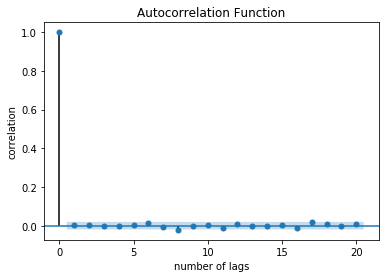

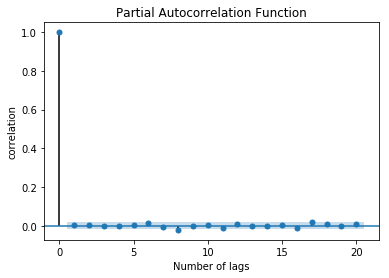

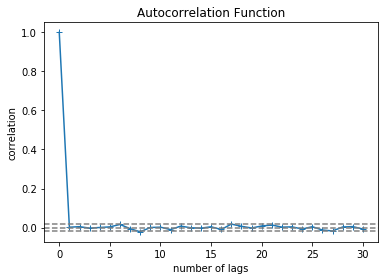

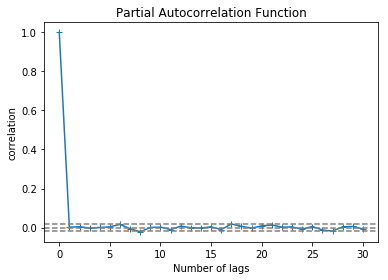

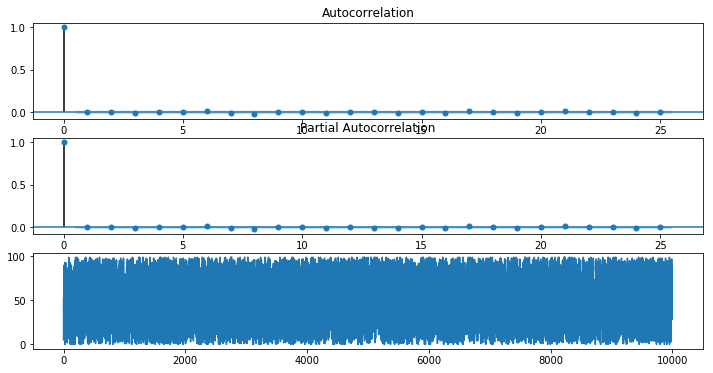

In [82]:
## imports
from __future__ import print_function, division

import pandas as pd
import numpy as np
import scipy.optimize
import scipy.signal
import scipy.stats

import statsmodels.api as sm
from statsmodels import tsa
from datetime import date, datetime, timedelta
import copy
import matplotlib.pyplot as plt

y = np.random.randint(0,100,10000)

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## SHORT
plot_acf(y, lags=20, alpha=.05, unbiased = True)
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.show()
plot_pacf(y, lags=20)
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.show()
fig11.tight_layout()

## MORE DETAILED
lag_acf = acf(y, nlags=30)
#Plot PACF:
plt.figure(figsize=(5.5, 4))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(5.5, 4))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()


fig, ax = plt.subplots(3, figsize=(12,6))
ax[0] = plot_acf(y, ax=ax[0], lags=25)
ax[1] = plot_pacf(y, ax=ax[1], lags=25)
ax[2].plot(y)

In [98]:
#Dickey Fuller
#https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
#Null: The series has a unit root
#Reject if t-stat < Crit
from statsmodels.tsa.stattools import adfuller
# returns ADF stat, McKinnon's pvalue, nb of lags used, nb of observations used, crit values
#regression can be c, constant, ct, constant with a trend, ctt, cttt
#store=True removes nb of lags and observations used, and adds a dummy class of results at end.
#Autolag != None, so the maximixed info criterion is also returned at end.

def adf_test(timeseries, print_res=True):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if print_res:
        print (dfoutput)
    return (dfoutput)
adf_test(y)

Results of Dickey-Fuller Test:
Test Statistic                  -99.798225
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


Test Statistic                  -99.798225
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64

-3.4310044252361025

In [92]:
#KPSS Test
#Null: trend stationary (vs has a unit root)
#Reject if t-stat is greater than crit
from statsmodels.tsa.stattools import kpss

# returns KPSS stat, pvalue, the truncation lag parameter, crit values
#regression can be c, constant, ct, constant with a trend
#store=True removes nb of lags and observations used, and adds a dummy class of results at end.

def kpss_test(timeseries, print_res=True):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    if print_res:
        print (kpss_output)
    return(kpss_output)
kpss_test(y)

Results of KPSS Test:
Test Statistic            0.499203
p-value                   0.041846
Lags Used                38.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Test Statistic            0.499203
p-value                   0.041846
Lags Used                38.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Both non stationary -> non stationary
Both stationary -> stationary
KPSS stationary but not ADF -> trend stationary
ADF stationary but not KPSS -> difference stationary

In [64]:
def is_stationary(timeseries):
    """Ascertains the stationarity of a given timeseries."""
    adf_output = adf_test(timeseries)
    kpss_output = kpss_test(timeseries)
    if adf_output[4] < adf_output[0] and kpss_output[4] < kpss_output[0]:
        print('Series is stationary at the 1% confidence level.')
    elif adf_output[6] > adf_output[0] and kpss_output[6] > kpss_output[0]:
        print('Series is not stationary at the 10% confidence level.')
        
    else:
        for i in range(4,7):
            if i == 4:
                level = 1
            elif i == 5:
                level = 5
            elif i == 6:
                level = 10
            
            if adf_output[i] < adf_output[0] and kpss_output[i] < kpss_output[0]:
                print("Series is stationary at the " + str(level) + "% level")
                break
            elif adf_output[i] < adf_output[0] and kpss_output[i] > kpss_output[0]:
                print("Series is difference stationary at the " + str(level) + "% level")
            elif adf_output[i] > adf_output[0] and kpss_output[i] < kpss_output[0]:
                print("Series is trend stationary at the " + str(level) + "% level")
            elif adf_output[i] > adf_output[0] and kpss_output[i] > kpss_output[0]:
                print("Series is not stationary at the " + str(level) + "% level")

In [ ]:
#Differencing
def differenciate(timeseries):
    #Differencing of a time series
    return timeseries - timeseries.shift(1)

def seasonal_differenciate(timeseries, n):
    #Deseasonalisation of a time series with a period of n.
    return timeseries - timeseries.shift(n)

In [ ]:
#Transformation
#Possible ones: log transform, square root, power transform (can be coupled with differencing)

In [81]:
#Exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#First order: Exponentially Weighted Moving Average
SES = SimpleExpSmoothing(y).fit()
predSES = SES.forecast(12)
#SES.fittedvalues

#Below, data MUST be positive
#Second order: Holt's: EWMA on both levels and trend
Holts = Holt(y, exponential=True).fit(smoothing_level=0.6, smoothing_slope=0.4, optimized=False)
predHolts = Holts.forecast(12)
#Holts.fittedvalues
#For both method, default is optimized=True and then you don't provide params
#For Holt, default is additive, thus why here we add exponential=True

#Third order: Holt Winters: on level, trend and seasonal components
from statsmodels.tsa.holtwinters import ExponentialSmoothing
HW = ExponentialSmoothing(saledata, seasonal_periods=4, trend='add', damped=False, seasonal='add').fit(use_boxcox=True)
predHW = HW.forecast(12)
#HW.fittedvalues
#Additive seasonality: seasonal variations cst through the seroes, multiplicative: changing proportionally
#to the level of the series
#ExponentialSmoothing(y, trend="additive", damped=False, seasonal=add, seasonal_period=12)
#trend can be add, mul, additive, multiplicative or None, same for seasonal
#damped to damp trend, and seasonal_period period.

In [ ]:
#holt Winters with plots
from statsmodels.tsa.holtwinters import ExponentialSmoothing
rain = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
model2 = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12, damped=True)
fit = model.fit()
pred = fit.forecast(24)
fit2 = model2.fit()
pred2 = fit2.forecast(24)

sse1 = np.sqrt(np.mean(np.square(test.values - pred.values)))
sse2 = np.sqrt(np.mean(np.square(test.values - pred2.values)))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[60:], train.values[60:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, pred, linestyle='--', color='#ff7823', label="w/o damping (RMSE={:0.2f}, AIC={:0.2f})".format(sse1, fit.aic));
ax.plot(test.index, pred2, linestyle='--', color='#3c763d', label="damped (RMSE={:0.2f}, AIC={:0.2f})".format(sse2, fit2.aic)); 
ax.legend();
ax.set_title("Holt-Winter's Seasonal Smoothing");

In [ ]:
#SARIMA prediction
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_st = df.ix[:-24, "station"]
test_st = df.ix[-24:, "station"]
sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction("1974-01", "1975-12")
predicted_means = p.predicted_mean + df.data.iloc[-36:-1].rolling(12).mean().dropna().values
predicted_intervals = p.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + df.data.iloc[-36:-1].rolling(12).mean().dropna().values
upper_bounds = predicted_intervals['upper station'] + df.data.iloc[-36:-1].rolling(12).mean().dropna().values

sarima_rmse = np.sqrt(np.mean(np.square(test_st.values - p.predicted_mean.values)))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df.data.index[100:-24], df.data.values[100:-24]);
ax.plot(test_st.index, test_st.values + df.data.iloc[-36:-1].rolling(12).mean().dropna().values, label='truth');
ax.plot(test_st.index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.2f})".format(sarima_rmse));
ax.fill_between(test_st.index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)");
ax.legend();
ax.set_title("SARIMA");

In [90]:
#Test normality, Jarque Bera test.
#If normal, the JB-stat follows asymptotically a Khi² distribution with 2 degrees of freedom.
#Null: Skewness = 0 AND Kurtosis = 0
from statsmodels.stats.stattools import jarque_bera

def JB_test(timeseries, print_res=True):
    print ('Results of KPSS Test:')
    JBtest = jarque_bera(timeseries, axis=0)
    JB_output = pd.Series(JBtest[0:4], index=['Test Statistic','p-value','Skew', 'Kurtosis'])
    if print_res:
        print (JB_output)
        if JBtest[1] < 0.01:
            print("We can reject normality at the 1% level")
        elif JBtest[1] < 0.05:
            print("We can reject normality at the 5% level")
        elif JBtest[1] < 0.1:
            print("We can reject normality at the 10% level")
        else:
            print("We cannot reject the null hypothesis at the 10% level")
    return(JB_output)
JB_test(y)

Results of KPSS Test:
Test Statistic     5.850976e+02
p-value           8.865036e-128
Skew              -1.835001e-03
Kurtosis           1.815002e+00
dtype: float64
We can reject normality at the 1% level


Test Statistic     5.850976e+02
p-value           8.865036e-128
Skew              -1.835001e-03
Kurtosis           1.815002e+00
dtype: float64